In [13]:
import mxnet as mx
import mxnet.ndarray as nd
from mxnet import gluon
from mxnet import autograd

from matplotlib import pyplot as plt
import numpy as np
import cv2
import random

from cnnviz.layers import Activation, Conv2D
from cnnviz import cnnviz

ctx = mx.gpu()

In [2]:
import os
from mxnet.gluon.model_zoo import model_store

from mxnet.gluon.nn import MaxPool2D, Flatten, Dense, Dropout, Activation
from cnnviz.layers import Conv2D

class AlexNet(mx.gluon.HybridBlock):
    def __init__(self, classes=1000, **kwargs):
        super(AlexNet, self).__init__(**kwargs)
        with self.name_scope():
            self.features = gluon.nn.HybridSequential(prefix='')
            with self.features.name_scope():
                self.features.add(Conv2D(64, kernel_size=11, strides=4, padding=2))
                self.features.add(Activation('relu'))
                self.features.add(MaxPool2D(pool_size=3, strides=2))

                self.features.add(Conv2D(192, kernel_size=5, padding=2))
                self.features.add(Activation('relu'))
                self.features.add(MaxPool2D(pool_size=3, strides=2))

                self.features.add(Conv2D(384, kernel_size=3, padding=1))
                self.features.add(Activation('relu'))

                self.features.add(Conv2D(256, kernel_size=3, padding=1))
                self.features.add(Activation('relu'))

                self.features.add(Conv2D(256, kernel_size=3, padding=1))
                self.features.add(Activation('relu'))
                self.features.add(MaxPool2D(pool_size=3, strides=2))

                self.features.add(Flatten())

                self.features.add(Dense(4096))
                self.features.add(Activation('relu'))
                self.features.add(Dropout(0.5))

                self.features.add(Dense(4096))
                self.features.add(Activation('relu'))
                self.features.add(Dropout(0.5))

            self.output = Dense(classes)

    def hybrid_forward(self, F, x):
        x = self.features(x)
        x = self.output(x)
        return x

def build_alexnet(pretrained=False, ctx=ctx,
            root=os.path.join('~', '.mxnet', 'models'), **kwargs):
    net = AlexNet(**kwargs)
    if pretrained:
        net.load_params(model_store.get_model_file('alexnet', root=root), ctx=ctx)
    return net

image_sz = (224, 224)

def preprocess(data):
    data = mx.image.imresize(data, image_sz[0], image_sz[1])
    data = data.astype(np.float32)
    data = data/255
    data = mx.image.color_normalize(data,
                                    mean=mx.nd.array([0.485, 0.456, 0.406]),
                                    std=mx.nd.array([0.229, 0.224, 0.225]))
    data = mx.nd.transpose(data, (2,0,1))
    return data

In [3]:
alexnet = build_alexnet(pretrained=True)

In [4]:
class LayerVisualizer(mx.gluon.Block):
    def __init__(self, net, layer_name, channel_num):
        super(LayerVisualizer, self).__init__()
        self.channel_num = channel_num
        self.net = net

        self.image = nd.array(np.uint8(np.random.uniform(150, 180, (224, 224, 3))))
        self.image = preprocess(self.image)
        self.image = self.image.expand_dims(axis=0)
        self.image = self.image.as_in_context(ctx)

        self.image = self.params.get('weight', init=mx.init.Constant(self.image), shape=self.image.shape)
        
        Conv2D.capture_layer_name = layer_name
    def forward(self):
        with ctx:
            y = self.net(self.image.data())
            return Conv2D.conv_output[0][self.channel_num]
        
def mean_loss(x):
    return nd.mean(x)

In [5]:
def recreate_image(img):
    recreated_im = img
    reverse_mean = [-0.485, -0.456, -0.406]
    reverse_std = [1/0.229, 1/0.224, 1/0.225]
    for c in range(3):
        recreated_im[c] /= reverse_std[c]
        recreated_im[c] -= reverse_mean[c]
    recreated_im[recreated_im > 1] = 1
    recreated_im[recreated_im < 0] = 0
    recreated_im = np.round(recreated_im * 255)

    recreated_im = np.uint8(recreated_im).transpose(1, 2, 0)
    recreated_im = recreated_im[..., ::-1]
    return recreated_im

In [37]:
def visualize_layer(layer_name, channel_num, lr):
    net = LayerVisualizer(alexnet, layer_name, channel_num=channel_num)
    net.collect_params(select='layervisualizer').initialize(ctx=ctx)
    trainer = mx.gluon.Trainer(net.collect_params(select='layervisualizer'), 'sgd', {'learning_rate': lr})

    for i in range(1000):
        with autograd.record(train_mode=True):
            y = net()
            loss = mean_loss(y)
        loss.backward()
        trainer.step(1)

    img = recreate_image(net.image.data()[0].asnumpy())
    return img

In [39]:
def visualize_random_channels(layer_name, num_channels, lr):
    imgs = []
    for channel in random.sample(range(num_channels), 4):
        imgs.append(visualize_layer(layer_name, channel, lr))
    return imgs

In [40]:
def show_images(images):
    fig=plt.figure(figsize=(15,15))
    rows, cols = 1, 4
    for i in range(4):
        fig.add_subplot(rows, cols, i+1)
        plt.imshow(images[i])
    plt.show()

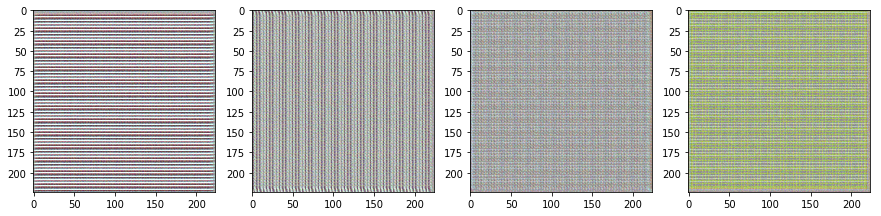

In [49]:
show_images(visualize_random_channels('alexnet0_conv2d0', 64, 10))

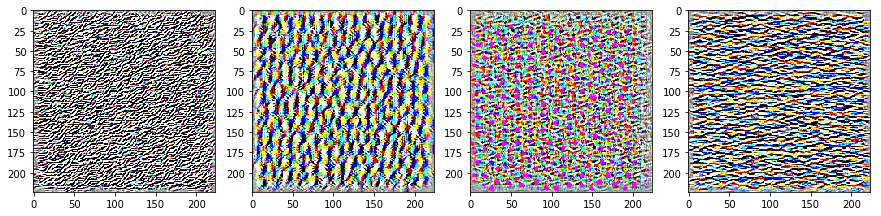

In [51]:
show_images(visualize_random_channels('alexnet0_conv2d1', 192, 5))

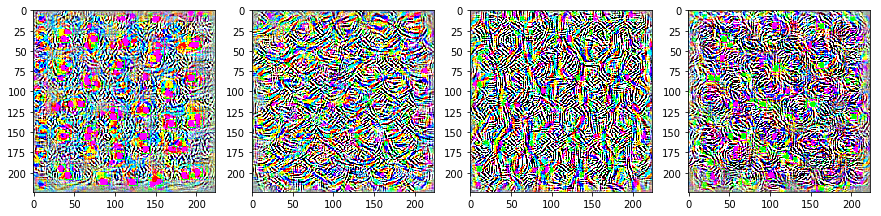

In [52]:
show_images(visualize_random_channels('alexnet0_conv2d2', 384, 3))

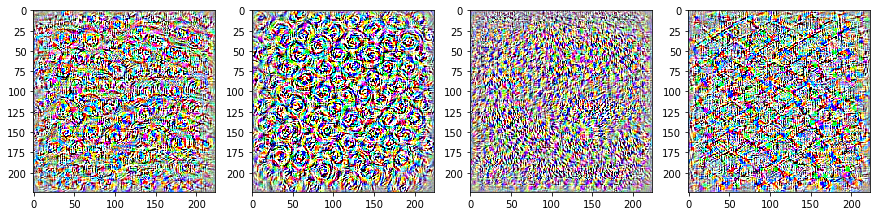

In [57]:
show_images(visualize_random_channels('alexnet0_conv2d3', 256, 1))

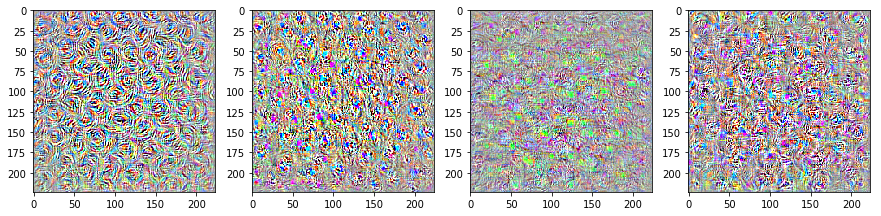

In [56]:
show_images(visualize_random_channels('alexnet0_conv2d4', 256, .5))